In [1]:
import pandas as pd
import numpy as np
import os
import gc
from tqdm import *
# 核心模型使用第三方库
import lightgbm as lgb
# 交叉验证所使用的第三方库
from sklearn.model_selection import StratifiedKFold, KFold
# 评估指标所使用的的第三方库
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import copy
import datetime
from chinese_calendar import is_workday
from numpy import nan
# 忽略报警所使用的第三方库
import pandas.util.testing as tm
import warnings
warnings.filterwarnings('ignore')


D:\anacondahoul\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_row', 1000)

In [6]:
train_data = pd.read_csv("D://数据挖掘竞赛//ccf//history//train.csv")
test_data = pd.read_csv("D://数据挖掘竞赛//ccf//history//evaluation_public.csv")

In [7]:
train_data['istest'] = 0
test_data['istest'] = 1

In [8]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [9]:
data['id_by_me'] = pd.Series(range(len(data)))

In [10]:
del data['ip_type']

# 特征工程

风险系数高的情况

In [11]:
data['is_forei/unknown'] = data['op_city'].apply(lambda x: 1 if x in['国外','未知'] else 0)

In [12]:
data['is_fail_code']=data['http_status_code'].apply(lambda x:0 if x==200 else 1)

In [13]:
data['is_code_5']=data['http_status_code'].apply(lambda x:1 if x in [500,502] else 0)

In [14]:
data['is_login_url'] = data['url'].apply(lambda x:1 if x in ['xxx.com/getVerifyCode','xxx.com/getLoginType'] else 0)

对时间进行简单处理

In [15]:
data['op_datetime'] = pd.to_datetime(data['op_datetime'])
data['day']=data['op_datetime'].astype(str).apply(lambda x:str(x)[5:10])
data['hour'] = data['op_datetime'].dt.hour
data['weekday'] = data['op_datetime'].dt.weekday+1

data = data.sort_values(by=['user_name', 'op_datetime']).reset_index(drop=True)

data['hour_sin'] = np.sin(data['hour']/24*2*np.pi)
data['hour_cos'] = np.cos(data['hour']/24*2*np.pi)

In [16]:
data['op_day'] = data['op_datetime'].astype(str).apply(lambda x:str(x)[8:10])

In [17]:
data['min'] = data['op_datetime'].apply(lambda x: int(str(x)[-5:-3]))
data['min_sin'] = np.sin(data['min']/60*2*np.pi)
data['min_cos'] = np.cos(data['min']/60*2*np.pi)

In [18]:
#user上次点击时间差
data['diff_last_1'] = data.groupby('user_name')['op_datetime'].apply(lambda i:i.diff(1)).dt.total_seconds()/60
data['diff_last_2'] = data.groupby('user_name')['op_datetime'].apply(lambda i:i.diff(2)).dt.total_seconds()/60

KeyboardInterrupt: 

In [ ]:
train_data = data[data['istest']==0]
test = data[data['istest']==1]

In [ ]:
#train：
train_data['diff_next'] = -(train_data.groupby('user_name')['op_datetime'].apply(lambda i:i.diff(-1))).dt.total_seconds()/60
data=pd.merge(data,train_data[['diff_next','id_by_me']],how='left', on='id_by_me')

In [ ]:
fea = ['user_name', 'department', 'ip_transform', 'device_num_transform', 'browser_version', 'browser',
          'os_type', 'os_version',  'op_city', 'log_system_transform', 'url']

In [ ]:
for col in fea:
    data[col+'_diff1_mean'] = data.groupby(col)['diff_last_1'].transform('mean')
    data[col+'_diff1_std'] = data.groupby(col)['diff_last_1'].transform('std')
    data[col+'_diff1_max'] = data.groupby(col)['diff_last_1'].transform('max')
    data[col+'_diff1_min'] = data.groupby(col)['diff_last_1'].transform('min')

In [ ]:
for col in fea:
    data[col+'_diff_next_mean'] = data.groupby(col)['diff_next'].transform('mean')
    data[col+'_diff_next_std'] = data.groupby(col)['diff_next'].transform('std')
    data[col+'_diff_next_max'] = data.groupby(col)['diff_next'].transform('max')
    data[col+'_diff_next_min'] = data.groupby(col)['diff_next'].transform('min')

In [ ]:
#data.drop(['browser_version_diff1_min','browser_diff1_min','os_type_diff1_min','os_version_diff1_min'],axis=1,inplace=True)

In [ ]:
data=data.fillna(-999)

特殊时间标记

In [ ]:
def is_fail_code(x):
    if x==200:
        return 0
    else:
        return 1

In [ ]:
#data['is_fail_code']=data['http_status_code'].apply(is_fail_code)

In [ ]:
data['is_fail_usr']=data['user_name'].apply(lambda x:1 if x == "-999" else 0)#登陆失败

In [ ]:
def isweekend(x):
    if(x<6):
        return 0
    else:
        return 1

In [ ]:
data['isweekend']=data['weekday'].apply(isweekend)

In [ ]:
def isnight(x):
    if (x>7)and(x<20):
        return 0
    else:
        return 1

In [ ]:
data['isnight'] = data['hour'].apply(isnight)

In [ ]:
for col in ['hour','weekday']:
    plt.figure(figsize=(15,5))
    sns.barplot(x=train_data[col],y = train_data['is_risk'])
    plt.savefig("D:\\数据挖掘竞赛\\ccf\\image\\{}.png".format(col),dpi=1000)

In [ ]:
#节假日放假
holiday = ['01-31','02-01', '02-02', '02-03', '02-04', '02-05', '02-06',
           '04-03','04-04', '04-05', '05-01', '05-02', '05-03', '05-04',
           '06-03', '06-04', '06-05']
def if_holiday(x):
    if x in holiday:
        return 1
    else:
        return 0
data['isholiday'] = data['op_datetime'].apply(lambda x:if_holiday(str(x)[5:10]))

In [ ]:
train_data=data[data['istest']==0]

In [ ]:
for col in ['isholiday']:
    plt.figure(figsize=(15,5))
    sns.barplot(x=train_data[col],y = train_data['is_risk'])
    plt.savefig("D:\\数据挖掘竞赛\\ccf\\image\\{}.png".format(col),dpi=1000)

In [ ]:
#调休
adjust = ['01-29', '01-30','04-02', '04-24','05-07']
def if_adjust(x):
    if x in adjust:
        return 1
    else:
        return 0
data['is_adjust'] = data['day'].apply(if_adjust)

In [ ]:
data['is_not_work'] = data['isweekend'].astype(bool)&(~data['is_adjust'])|(data['isholiday'].astype(bool))

将特殊时间点与用户登陆行为结合

In [ ]:
time_fea=['hour','weekday','min','isnight','isholiday','is_not_work']

In [ ]:
for col in time_fea:
    data[col+'_diff1_mean_u'] = data.groupby(['user_name',col])['diff_last_1'].transform('mean')
    data[col+'_diff1_std_u'] = data.groupby(['user_name',col])['diff_last_1'].transform('std')

In [ ]:
for col in time_fea:
    data[col+'_diff1_next_mean_u'] = data.groupby(['user_name',col])['diff_next'].transform('mean')
    data[col+'_diff1_next_std_u'] = data.groupby(['user_name',col])['diff_next'].transform('std')

In [ ]:
del data['diff_next']

0点-当前usr使用某属性的次数

In [ ]:
cols = ['id_by_me','user_name','ip_transform', 'device_num_transform',
       'browser_version', 'browser', 'os_type', 'os_version','http_status_code','op_city',
        'log_system_transform','url','op_datetime']

In [ ]:
tmp=data[cols]

In [ ]:
tmp['op_day'] = tmp['op_datetime'].dt.date

In [ ]:
tmp = tmp.groupby(['user_name','op_day'],as_index=False).agg({'id_by_me':list,'ip_transform':list, 'device_num_transform':list,
       'browser_version':list, 'browser':list, 'os_type':list, 'os_version':list,'http_status_code':list,'op_city':list,
        'log_system_transform':list,'url':list})

In [ ]:
def get_which_time(col_unique,fea):
    fea_dict = dict.fromkeys(col_unique,0)
    count_list=[]
    for i in range(len(fea)):
        fea_dict[fea[i]] = fea_dict[fea[i]]+1
        count_list.append(fea_dict[fea[i]])
    return count_list

In [ ]:
for col in tqdm(['ip_transform', 'device_num_transform',
       'browser_version', 'browser', 'os_type', 'os_version','http_status_code','op_city',
        'log_system_transform','url']):
    col_unique=data[col].unique()
    tmp[col+'_countls'] = tmp[col].apply(lambda x:get_which_time(col_unique,x))

In [ ]:
tmp=tmp.explode(['id_by_me', 'ip_transform',
       'device_num_transform', 'browser_version', 'browser', 'os_type',
       'os_version', 'http_status_code', 'op_city', 'log_system_transform',
       'url', 'ip_transform_countls',
       'device_num_transform_countls', 'browser_version_countls',
       'browser_countls', 'os_type_countls', 'os_version_countls',
       'http_status_code_countls', 'op_city_countls',
       'log_system_transform_countls', 'url_countls'])

In [ ]:
tmp = tmp.reset_index(drop=True)

In [ ]:
cols=['id_by_me','ip_transform_countls', 'device_num_transform_countls',
       'browser_version_countls', 'browser_countls', 'os_type_countls',
       'os_version_countls', 'http_status_code_countls', 'op_city_countls',
       'log_system_transform_countls', 'url_countls']

In [ ]:
data=pd.merge(data,tmp[cols],on='id_by_me',how='left')

In [ ]:
for col in ['ip_transform_countls', 'device_num_transform_countls',
       'browser_version_countls', 'browser_countls', 'os_type_countls',
       'os_version_countls', 'http_status_code_countls', 'op_city_countls',
       'log_system_transform_countls', 'url_countls']:
    data[col] = data[col].astype(int)

In [ ]:
train_data=data[data['istest']==0]

账号最近一段时间登陆的ip种类

In [ ]:
cols = ['id_by_me','user_name','ip_transform', 'device_num_transform','browser_version', 'browser', 'os_type', 
                 'os_version','http_status_code','op_city','log_system_transform','url','op_datetime']
tmp=data[cols]

In [ ]:
#账号最近几次登陆
for x in range(1,30):
    tmp['usr_diff_last_'+str(x)] = tmp.groupby(['user_name'])['op_datetime'].apply(lambda i:i.diff(x)).dt.total_seconds()/60
merge_cols = [col for col in tmp.columns if '_diff_last_' in col]
tmp['ip_diff_list_30']=tmp[merge_cols].values.tolist()
tmp.drop(merge_cols,axis=1,inplace=True)

In [ ]:
#账号最近几次登陆对应ip
for x in range(1,30):
    tmp['usr_last_ip'+str(x)] = tmp.groupby(['user_name'])['ip_transform'].apply(lambda i:i.shift(x))
merge_cols = [col for col in tmp.columns if '_last_' in col]
tmp['usr_ip_list_30']=tmp[merge_cols].values.tolist()
tmp.drop(merge_cols,axis=1,inplace=True)

In [ ]:
def get_nunique_minute(diff_list,uni_list,minute):
    ls=[]
    for i in range(len(diff_list)):
        if diff_list[i]<minute:
            ls.append(uni_list[i])
        else:
            break
    return pd.Series(ls).nunique()

In [ ]:
tmp['ip_time_nui_6'] = tmp.apply(lambda row:get_nunique_minute(row['ip_diff_list_30'],row['usr_ip_list_30'],60*6),axis=1)

In [ ]:
tmp['ip_time_nui_12'] = tmp.apply(lambda row:get_nunique_minute(row['ip_diff_list_30'],row['usr_ip_list_30'],60*12),axis=1)

In [ ]:
tmp['ip_time_nui_24'] = tmp.apply(lambda row:get_nunique_minute(row['ip_diff_list_30'],row['usr_ip_list_30'],60*24),axis=1)

In [ ]:
cols=[col for col in tmp.columns if 'ip_time_nui_'in col]

In [ ]:
cols.append('id_by_me')

In [ ]:
data=pd.merge(data,tmp[cols],on='id_by_me',how='left')

交叉特征

In [ ]:
cross_cols=[]

In [ ]:
#department_city
data['department_op_city'] = data['department'].astype(str)+data['op_city'].astype(str)
cross_cols.append('department_op_city')

In [ ]:
#department_log_system_transform
data['department_log_system_transform'] = data['department'].astype(str)+data['log_system_transform'].astype(str)
#data['department_log_system_transform'] = label_encoder(data['department_log_system_transform'])
cross_cols.append('department_log_system_transform')

In [ ]:
#browser_version_op_city
data['browser_version_op_city'] = data['browser_version'].astype(str)+data['op_city'].astype(str)
#data['browser_version_op_city'] = label_encoder(data['browser_version_op_city'])
cross_cols.append('browser_version_op_city')

In [ ]:
#browser_op_city
data['browser_op_city'] = data['browser'].astype(str)+data['op_city'].astype(str)
#data['browser_op_city'] = label_encoder(data['browser_op_city'])
cross_cols.append('browser_op_city')

In [ ]:
#browser_log_system_transform
data['browser_log_system_transform'] = data['browser'].astype(str)+data['log_system_transform'].astype(str)
#data['browser_log_system_transform'] = label_encoder(data['browser_log_system_transform'])
cross_cols.append('browser_log_system_transform')

In [ ]:
#os_type_op_city
data['os_type_op_city'] = data['os_type'].astype(str)+data['op_city'].astype(str)
#data['os_type_op_city'] = label_encoder(data['os_type_op_city'])
cross_cols.append('os_type_op_city')

In [ ]:
#os_type_log_system_transform
data['os_type_log_system_transform'] = data['os_type'].astype(str)+data['log_system_transform'].astype(str)
#data['os_type_log_system_transform'] = label_encoder(data['os_type_log_system_transform'])
cross_cols.append('os_type_log_system_transform')

In [ ]:
#os_version_op_city
data['os_version_op_city'] = data['os_version'].astype(str)+data['op_city'].astype(str)
#data['os_version_op_city'] = label_encoder(data['os_version_op_city'])
cross_cols.append('os_version_op_city')

In [ ]:
#os_type_log_system_transform
data['os_type_log_system_transform'] = data['os_type'].astype(str)+data['log_system_transform'].astype(str)
#data['os_type_log_system_transform'] = label_encoder(data['os_type_log_system_transform'])
cross_cols.append('os_type_log_system_transform')

In [ ]:
#op_city_log_system_transform
data['op_city_log_system_transform'] = data['op_city'].astype(str)+data['log_system_transform'].astype(str)
#data['op_city_log_system_transform'] = label_encoder(data['op_city_log_system_transform'])
cross_cols.append('op_city_log_system_transform')

In [ ]:

#departmen_url
data['op_city_log_system_transform'] = data['department'].astype(str)+data['log_system_transform'].astype(str)
#data['op_city_log_system_transform'] = label_encoder(data['op_city_log_system_transform'])
cross_cols.append('op_city_log_system_transform')

用户在某hour使用某属性的count

In [ ]:
cols = ['ip_transform', 'device_num_transform',
       'browser_version', 'browser', 'os_type', 'os_version',
       'http_status_code', 'op_city', 'log_system_transform', 'url']

In [ ]:
for col in cols:
    tmp = data[data['istest']==0].groupby(['user_name',col,'hour'])['is_risk'].count().reset_index()
    tmp.columns=['user_name',col,'hour',col+'_hour_count']
    data=pd.merge(data,tmp,on=['user_name',col,'hour'],how='left')

工作日/节假日登陆某属性的count

In [ ]:
tmp = data[data['istest']==0].groupby(['user_name','is_not_work','hour'],as_index=False)['is_risk'].agg({'work_hour_count':'count'})
data = pd.merge(data,tmp,how='left',on=['user_name','is_not_work','hour'])

In [ ]:
date_fea = ['weekday','isholiday']

In [ ]:
for col in date_fea:
    tmp = data[data['istest']==0].groupby(['user_name',col,'hour'],as_index=False)['is_risk'].agg({col+'_count':'count'})
    data = pd.merge(data,tmp,how='left',on=['user_name',col,'hour'])

In [ ]:
numeric_features = data.select_dtypes(include=[np.number])
categorical_features = data.select_dtypes(include=[np.object])

In [ ]:
import category_encoders as ce
data[categorical_features.columns] = ce.OrdinalEncoder().fit_transform(data[categorical_features.columns])

In [ ]:
from mvtpy.mvtest import mvtest
fea = [col for col in data.columns if col not in['id','index','id_by_me','op_datetime', 'op_day','day', 'op_month','is_risk', 'ts', 'ts1', 'ts2', 'diff_next']]
model = mvtest()


In [ ]:
train_data = data[data['istest']==0]
test = data[data['istest']==1]

In [ ]:
list({'Tn': 0.22, 'p-value': [0.2, 0.25]}.values())[0]

In [ ]:
list_t = []
list_name=[]

In [ ]:
for col in tqdm(fea):
    t = list(model.test(train_data[col],train_data['is_risk']).values())[0]
    list_t.append(t)
    list_name.append(col)

In [ ]:
tn_value = pd.DataFrame({'fea':list_name,'Tn':list_t})

In [ ]:
tn_value.to_csv('D:\\数据挖掘竞赛\\ccf\\tn_value.csv',index=False)

In [ ]:
tn_value = tn_value.reset_index(drop=True)

In [20]:
tn_value = pd.read_csv('D:\\数据挖掘竞赛\\ccf\\tn_value.csv')

In [21]:
tn_value = tn_value.reset_index(drop=True)

In [22]:
tn_value=tn_value.sort_values(by='Tn').reset_index()[169:]

In [23]:
tn_value

,index,fea,Tn
169,173,op_city_hour_count,158.68
170,119,is_not_work,169.33
171,152,log_system_transform_countls,173.45
172,167,device_num_transform_hour_count,181.50
173,176,work_hour_count,202.85
174,14,is_fail_code,398.84
175,8,http_status_code,402.35
176,166,ip_transform_hour_count,419.05
177,116,isnight,431.72
178,172,http_status_code_hour_count,606.73


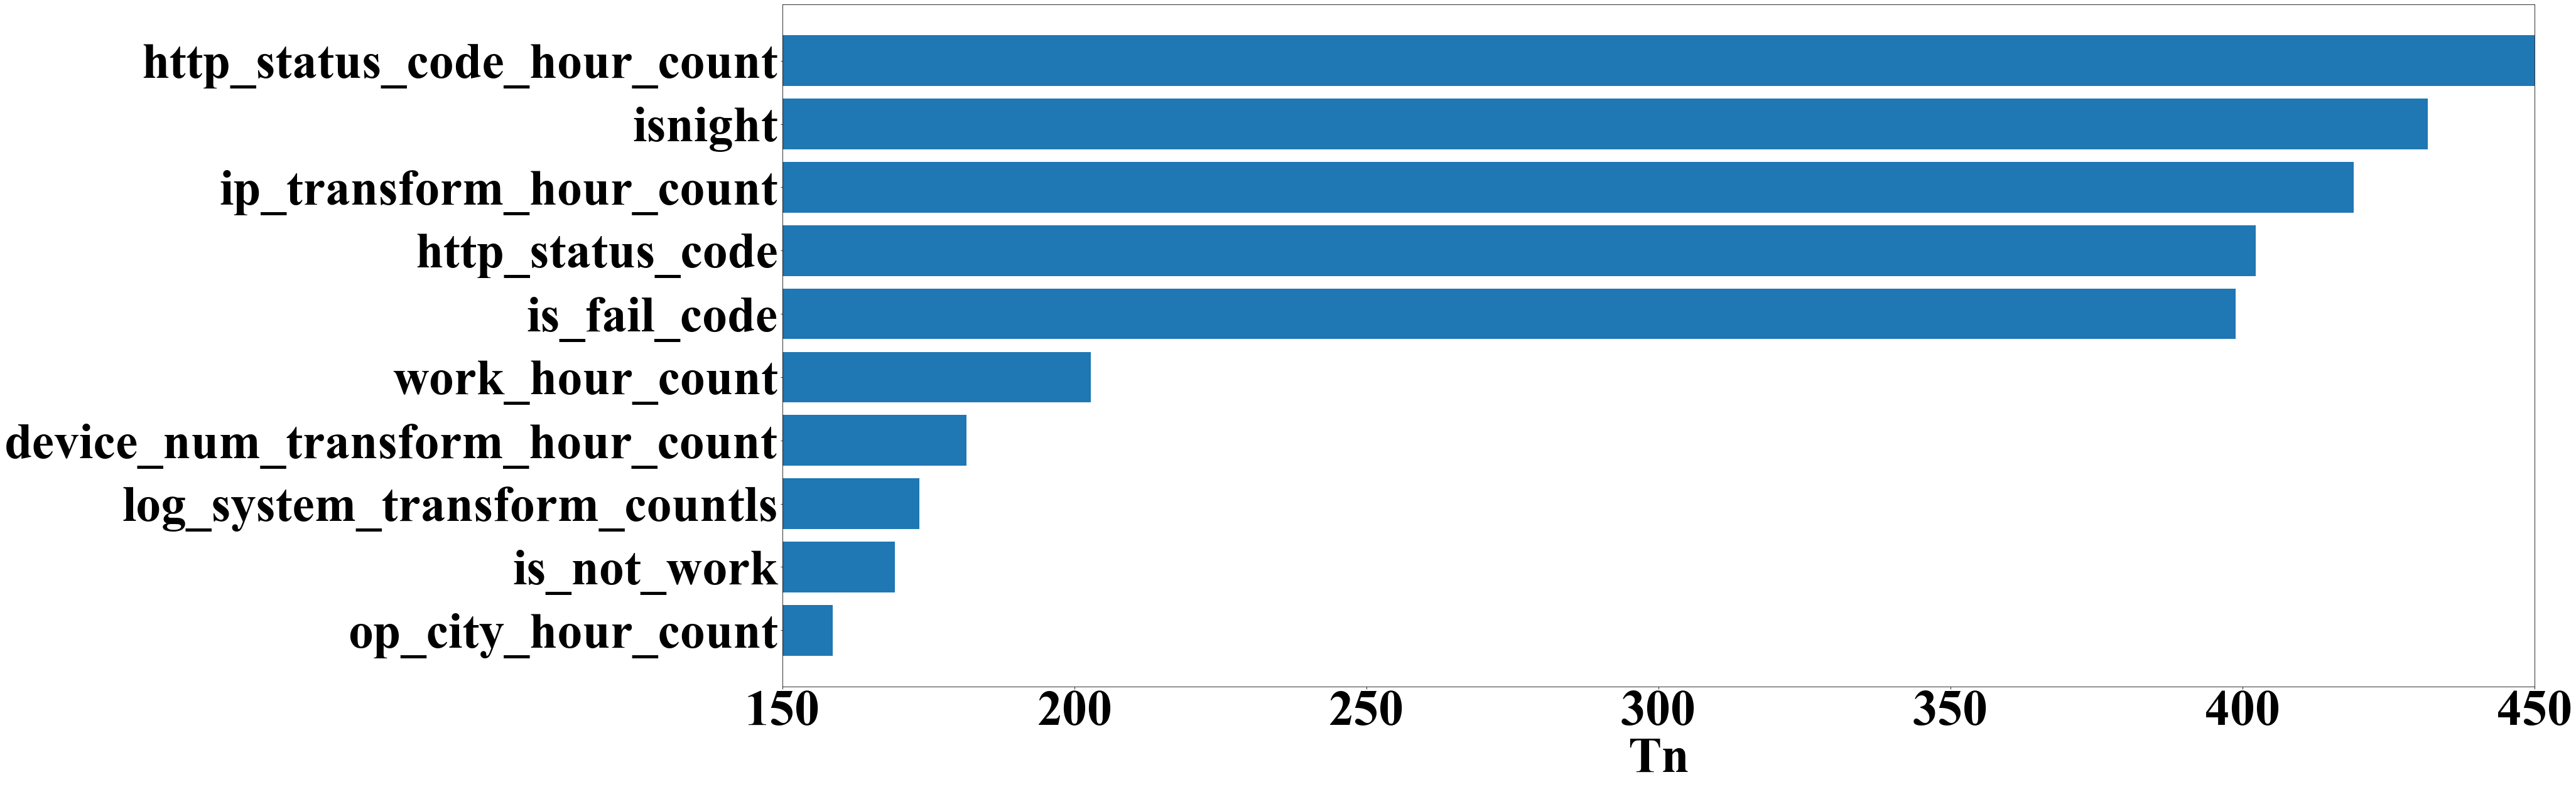

In [39]:
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.size']=80
plt.figure(figsize=(50,20))
plt.barh(tn_value[:50]['fea'], tn_value[:50]['Tn'])
plt.xlabel('Tn')
myticks = np.arange(0,460,50)
plt.yticks(fontproperties='Times New Roman',weight='bold',size = 80)#设置大小及加粗
plt.xticks(myticks)
plt.xticks(fontproperties='Times New Roman',weight='bold',size = 80)
plt.xlim(150,450)
plt.savefig("D:\\数据挖掘竞赛\\ccf\\image\\tn.pdf",dpi=1000,bbox_inches='tight')

In [146]:
tn_value

,fea,Tn
0,http_status_code_hour_count,606.73
1,isnight,431.72
2,ip_transform_hour_count,419.05
3,http_status_code,402.35
4,is_fail_code,398.84
5,work_hour_count,202.85
6,device_num_transform_hour_count,181.50
7,log_system_transform_countls,173.45
8,is_not_work,169.33
9,op_city_hour_count,158.68


In [129]:
t

148.81

In [83]:
train_data = data[data['istest']==0]
test = data[data['istest']==1]

In [84]:
test = test.sort_values('id').reset_index(drop=True)

In [85]:
train = train_data[train_data['op_datetime']<'2022-04-01'].reset_index(drop=True)
val = train_data[train_data['op_datetime']>='2022-04-01'].reset_index(drop=True)

In [86]:
fea = [col for col in data.columns if col not in['id','index','id_by_me','op_datetime', 'op_day','day', 'op_month','is_risk', 'ts', 'ts1', 'ts2', 'diff_next']]

In [87]:
x_train = train[fea]
y_train = train['is_risk']

x_val = val[fea]
y_val = val['is_risk']

x_test = test[fea]
y_test = test['is_risk']

In [88]:
importance = 0
pred_y = pd.DataFrame()
var_pre = pd.DataFrame()

lgb_score_list = []

seeds=2022

In [89]:
params_lgb  = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 64,
    'verbose': -1,
    'seed': 2022,
    'n_jobs': -1,

    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    # 'min_child_weight': 10,
    "min_data_in_leaf":20
}


In [90]:
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)
kf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    print('************************************ {} {}************************************'.format(str(i+1), str(seeds)))
    trn_x, trn_y, val_x, val_y = x_train.iloc[train_idx],y_train.iloc[train_idx], x_train.iloc[val_idx], y_train.iloc[val_idx]
    train_data = lgb.Dataset(trn_x,
                        trn_y)
    val_data = lgb.Dataset(val_x,
                        val_y)
    model = lgb.train(params_lgb, train_data, valid_sets=[val_data], num_boost_round=20000,
                      callbacks=[lgb.early_stopping(100), lgb.log_evaluation(2000)])

    pred_y['fold_%d_seed_%d' % (i, seeds)] = model.predict(x_test)
    var_pre['fold_%d_seed_%d' % (i, seeds)] = model.predict(x_val)
    
    importance += model.feature_importance(importance_type='gain') / 5
    lgb_score_list.append(auc(val_y, model.predict(val_x)))

************************************ 1 2022************************************
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.943887
************************************ 2 2022************************************
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.944708
************************************ 3 2022************************************
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.942759
************************************ 4 2022************************************
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.9439
************************************ 5 2022************************************
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:


In [91]:
test['is_risk'] = pred_y.mean(axis=1).values

In [92]:
df_test = pd.read_csv('../raw_data/evaluation_public.csv')
df_test = pd.merge(df_test,test[['id','is_risk']],how='left')
df_test['op_datetime'] = pd.to_datetime(df_test['op_datetime'])
df_test = df_test.sort_values('op_datetime').reset_index(drop=True)
df_test['hour'] = df_test['op_datetime'].dt.hour
df_test.loc[df_test['hour']<6,'is_risk'] = 1
df_test.loc[df_test['hour']>20,'is_risk'] = 1

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/evaluation_public.csv'

In [ ]:
df_test[['id','is_risk']].to_csv("../prediction_result/result.csv", index=False)